In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix,accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [3]:
mp_holistic = mp.solutions.holistic # inicia el modelo donde podemos seguir los puntos del cuerpo humano, incluyendo pose, mano y caras.
mp_drawing = mp.solutions.drawing_utils # inicializa el dibujado o trazados de los puntos del modelo.
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh

In [4]:
def mediapipe_detection(image, model):
    """
    OpenCV carga las imágenes en el formato BGR por defecto. Sin embargo, 
    muchos modelos de procesamiento de imágenes, 
    incluido MediaPipe, esperan que las imágenes estén en formato RGB. 
    Por lo tanto, esta funcion convierte la imagen del formato BGR a RGB y devuelve la posición de
    los puntos  clave del cuerpo, la mano y la cara.
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_styled_landmarks(image,results):
    """
        La función permite conectar los puntes de referenica a la imagen y luego dibuja
        las conexiones, permitiendo ver (mallas).
    """
    # Dibuja los landmarks del cuerpo
    mp_drawing.draw_landmarks(image, #Toma como referencia la imagen capturada
                                  results.pose_landmarks, #Toma como referencia los puntos predecidos por el modelo Holistic.
                                  mp_pose.POSE_CONNECTIONS, #Conecta cada punto predecidos.
                                  mp_drawing.DrawingSpec( #Funcion que personaliza los puntos predecidos.
                                                         color=(80,22,10), #Color del punto
                                                         thickness=2, #Grosor del punto
                                                         circle_radius=4), #Radio del circulo.
                                  mp_drawing.DrawingSpec( #Funcion que personaliza las conexiones predecidas.
                                                         color=(80,44,121),
                                                         thickness=2,
                                                         circle_radius=2))
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION,mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1),mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1))
    mp_drawing.draw_landmarks(image, results.face_landmarks,mp_face_mesh.FACEMESH_CONTOURS,mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1),mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_hands.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(121,22,76),thickness=2,circle_radius=4),mp_drawing.DrawingSpec(color=(121,44,250),thickness=2,circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_hands.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(245,117,66),thickness=2,circle_radius=4),mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2))

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    """
        Aquí se está configurando el modelo Holistic de MediaPipe con una confianza mínima de detección de 0.5 y 
        una confianza mínima de seguimiento de 0.5. 
        El uso del with asegura que los recursos se liberen adecuadamente cuando se termina el bloque de código.
    """
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read() #ret es solo un booleano que indica si la captura fue exitosa o no, frame es la imagen.

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        draw_styled_landmarks(image,results)

        print('Cuerpo:',results.pose_landmarks)   # Puntos clave del cuerpo
        print('Cara:',results.face_landmarks)   # Puntos clave de la cara
        print('Mano Izquierda:',results.left_hand_landmarks)  # Puntos clave de la mano izquierda
        print('Mano Derecha:', results.right_hand_landmarks) # Puntos clave de la mano derecha

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [9]:
cap.release()
cv2.destroyAllWindows()

In [20]:
# frame.shape
# frame
results

mediapipe.python.solution_base.SolutionOutputs

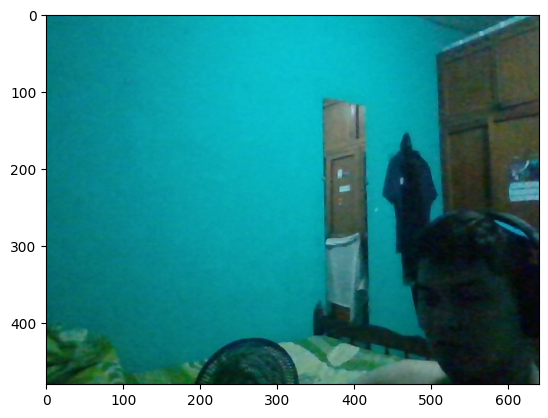

In [6]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))

In [7]:
draw_styled_landmarks(frame,results)

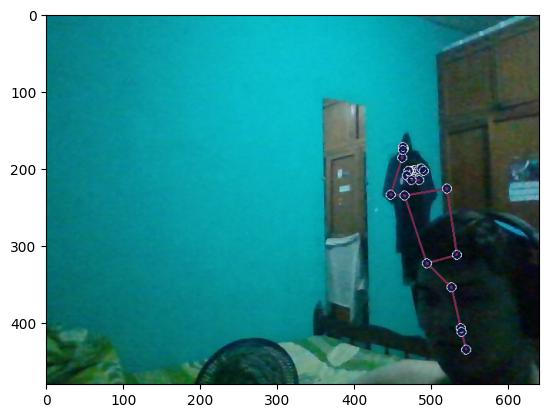

In [8]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))

In [9]:
# results.pose_landmarks.landmark
results.pose_landmarks.landmark[0]
# results.pose_landmarks.landmark[0].x

x: 0.743431687
y: 0.644119799
z: -0.842995048
visibility: 0.999950945

In [16]:
res = results.pose_landmarks.landmark[0]
res.x,res.y,res.z,res.visibility
test = np.array([res.x,res.y,res.z,res.visibility])
test

array([ 0.74343169,  0.6441198 , -0.84299505,  0.99995095])

In [17]:
pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

In [ ]:
pose

In [19]:
len(results.pose_landmarks.landmark)*4 #Bien, en este punto se explica que el total de puntos obtenidos es 33 por cada coordenada, lo que daria un total de 132 puntos, misma cantidad debe ser el array de ceros en caso tal de que no detecte valores para la pose.

132

In [20]:
pose.shape

(132,)

In [21]:
pose.ndim

1

In [ ]:
len(results.left_hand_landmarks.landmark)

In [23]:
len(results.right_hand_landmarks.landmark)

21

In [24]:
lh = np.array([[res.x,res.y,res.z]for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

In [26]:
rh = np.array([[res.x,res.y,res.z]for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [27]:
len(results.left_hand_landmarks.landmark)*3

AttributeError: 'NoneType' object has no attribute 'landmark'

In [28]:
# lh
rh

array([ 3.37040901e-01,  6.89947128e-01,  3.85277161e-07,  3.93917799e-01,
        6.71472311e-01, -2.52763852e-02,  4.35905695e-01,  6.18556499e-01,
       -3.52947414e-02,  4.64500636e-01,  5.69495499e-01, -4.37693037e-02,
        4.93881792e-01,  5.50139666e-01, -5.22779562e-02,  4.10414696e-01,
        5.05309820e-01, -2.44773198e-02,  4.40798402e-01,  4.33447540e-01,
       -4.10119966e-02,  4.52935398e-01,  3.84296507e-01, -5.44894896e-02,
        4.58724022e-01,  3.41283351e-01, -6.49827570e-02,  3.72393250e-01,
        4.84520406e-01, -2.50630789e-02,  3.78612727e-01,  3.88678223e-01,
       -4.04301099e-02,  3.77385050e-01,  3.29446614e-01, -5.31609580e-02,
        3.72603446e-01,  2.81916946e-01, -6.20640367e-02,  3.37108940e-01,
        4.87011760e-01, -2.83036977e-02,  3.31290662e-01,  4.00994360e-01,
       -4.51703332e-02,  3.25834423e-01,  3.47076178e-01, -5.82767613e-02,
        3.19798619e-01,  3.02997053e-01, -6.67800456e-02,  3.03527534e-01,
        5.08710802e-01, -

In [29]:
len(results.face_landmarks.landmark)

468

In [30]:
face = np.array([[res.x,res.y,res.z]for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)

In [5]:
def extract_keypoints(results):
    face = np.array([[res.x,res.y,res.z]for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    rh = np.array([[res.x,res.y,res.z]for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    lh = np.array([[res.x,res.y,res.z]for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    pose = np.array([[res.x,res.y,res.z,res.visibility]for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return np.concatenate([pose,face,lh,rh])

In [32]:
extract_keypoints(results)

array([ 0.74343169,  0.6441198 , -0.84299505, ...,  0.25871179,
        0.37613726, -0.06393809])

In [33]:
extract_keypoints(results).shape

(1662,)

In [11]:
DATA_PATH = os.path.join('MP_Data')
category = {
    'VOCALES': ['A','E','I','O','U'],
    'PRONOMBRES':['TU','YO','EL','ELLA'],
    'DIAS':['LUNES','JUEVES','VIERNES'],
    'ADJETIVOS':['FEO','BONITO','INTELIGENTE'],
    'ALIMENTOS':['HUEVO','JUGO','LECHE','CAFE'],
    'TIEMPO':['MANANA','BUENOS DIAS','BUENAS TARDES','BUENAS NOCHES','AYER','HOY'],
    'VERBOS':['BUSCAR','MENTIR','HABLAR','ESCRIBIR'],
    'COLORES':['ROJO','AMARILLO','VERDE'],
    'PROVINCIAS':['PANAMA','BOCAS DEL TORO','VERAGUAS'],
    'PROFESIONES':['INGENIERO','POLICIA'],
    'TRANSPORTES':['BUS','MOTO','BICICLETA'],
    'ANIMALES':['GALLO','PERRO','TORTUGA','GATO'],
    'PERSONAS':['PAPA','MAMA','HOMBRE','MUJER','SENOR'],
}
no_videos = 30
no_frames = 30

In [12]:
actions = np.array([value for values in category.values() for value in values])

In [13]:
actions

array(['A', 'E', 'I', 'O', 'U', 'TU', 'YO', 'EL', 'ELLA', 'LUNES',
       'JUEVES', 'VIERNES', 'FEO', 'BONITO', 'INTELIGENTE', 'HUEVO',
       'JUGO', 'LECHE', 'CAFE', 'MANANA', 'BUENOS DIAS', 'BUENAS TARDES',
       'BUENAS NOCHES', 'AYER', 'HOY', 'BUSCAR', 'MENTIR', 'HABLAR',
       'ESCRIBIR', 'ROJO', 'AMARILLO', 'VERDE', 'PANAMA',
       'BOCAS DEL TORO', 'VERAGUAS', 'INGENIERO', 'POLICIA', 'BUS',
       'MOTO', 'BICICLETA', 'GALLO', 'PERRO', 'TORTUGA', 'GATO', 'PAPA',
       'MAMA', 'HOMBRE', 'MUJER', 'SENOR'], dtype='<U14')

In [11]:
for action in actions:
    for no_video in range(no_videos):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(no_video)))
        except:
            pass

## Captura Manual por cada seña.

In [ ]:
cap = cv2.VideoCapture(0)
superBrake = False
sign = input('Escribe la seña a capturar: ')
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    """
        Aquí se está configurando el modelo Holistic de MediaPipe con una confianza mínima de detección de 0.5 y 
        una confianza mínima de seguimiento de 0.5. 
        El uso del with asegura que los recursos se liberen adecuadamente cuando se termina el bloque de código.
    """
    if sign in actions:
         while True:
             ret,image = cap.read()
             cv2.imshow('Recolectando Datos',image)
             if cv2.waitKey(10) & 0xFF == ord('q'):
                 break

         for no_video in range(no_videos): #Numero de video accion
            if superBrake:
                break
            cv2.waitKey(1000) #2000
            # cv2.waitKey(0) #Si le pasamos como argumento cero, nos pasara al siguiente frame al momento de presionar una tecla.

            for frame_num in range(no_frames):#Numero de frame por video por accion
                # Read feed
                ret, frame = cap.read() #ret es solo un booleano que indica si la captura fue exitosa o no, frame es la imagen.

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                draw_styled_landmarks(image,results)
                # print('Cuerpo:',results.pose_landmarks)   # Puntos clave del cuerpo
                # print('Cara:',results.face_landmarks)   # Puntos clave de la cara
                # print('Mano Izquierda:',results.left_hand_landmarks)  # Puntos clave de la mano izquierda
                # print('Mano Derecha:', results.right_hand_landmarks) # Puntos clave de la mano derecha
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,sign,str(no_video),str(frame_num))
                # np.save(npy_path,keypoints)

                
                if no_video + 1 == no_videos and frame_num + 1 == no_frames:
                    cv2.putText(image,'PRESIONE CUALQUIERA TECLA PARA SALIR',(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),2,cv2.LINE_AA)
                    cv2.putText(image,'RECOLECTANDO VIDEO #{} PARA LA SENA <<{}>>'.format(no_video+1,sign),(15,35),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.putText(image,'FRAME CAPTURADO #{}'.format(frame_num+1),(15,60),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.imshow('Recolectando Datos',image)
                    cv2.waitKey(0)
                else: 
                    cv2.putText(image,'RECOLECTANDO VIDEO #{} PARA LA SENA <<{}>>'.format(no_video+1,sign),(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.putText(image,'FRAME CAPTURADO #{}'.format(frame_num+1),(15,30),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.imshow('Recolectando Datos',image)
                
                # cv2.imshow('Recolectando Datos',image)
                
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    superBrake = True
                    break

    else:
        print(f'La seña <{sign}> no se encuentra en el diccionario establecido para esta prueba.')

    cap.release()
    cv2.destroyAllWindows()

In [17]:
cap.release()
cv2.destroyAllWindows()